In [21]:
import re
import os
import random as rd
import tensorflow as tf
import matplotlib.pyplot as plt
import pyBigWig as pbg
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.stats
from scipy import sparse

In [2]:
def ohe(seq):
    seq2=list()
    mapping = {"A":[1, 0, 0, 0], "C": [0, 1, 0, 0], "G": [1, 0, 0, 0], "T":[0, 0, 0, 1]}
    for i in seq:
      seq2.append(mapping[i]  if i in mapping.keys() else [0, 0, 0, 0]) 
    return np.array(seq2)

In [4]:
#fasta to ohe numpy
f=open('/home/florian/projet/r6.16/dmel-all-chromosome-r6.16.fasta','r')
os.chdir('/home/florian/projet/r6.16')
chr_name = str()
seq=[]
D={}
for line in f:
        line = line.rstrip()
        if line[0] == '>':
                if line[1:3]=="2C":
                        break
                if seq != []:
                        D[chr_name]=ohe(seq)
                chr_name = line[1:3].strip()
                seq = []
        else:
                seq += line
D["Y"]=ohe(seq)
np.savez_compressed('seq',**D)

In [35]:
#bigwig to numpy
os.chdir('/home/florian/projet/scATACseq')
fichiers=os.listdir('/home/florian/projet/scATACseq')
valeurs = []
array=np.array(())
for file in fichiers:
    #print("processing file", file)
    bw=pbg.open(file)
    array = np.concatenate((bw.values("2L",0,-1,numpy=True),bw.values("2R",0,-1,numpy=True),bw.values("3R",0,-1,numpy=True),bw.values("3L",0,-1,numpy=True),bw.values("4",0,-1,numpy=True),bw.values("X",0,-1,numpy=True),bw.values("Y",0,-1,numpy=True)))
    if len(valeurs) == 0:
        valeurs = array
    else:
        valeurs += array
os.chdir('/home/florian/projet')
np.savez_compressed('scATACseq',valeurs=valeurs)

In [51]:
#bigwig to numpy v2
os.chdir('/home/florian/projet/scATACseq')
fichiers=os.listdir('/home/florian/projet/scATACseq')
valeurs =[]
chr=["2L","2R","3R","3L","4","X","Y"]
Dic={"2L"}
for file in fichiers:
    #print("processing file", file)
    bw=pbg.open(file)
    array = np.array(())
    for j in chr:
        array=np.append(array,bw.values(j,0,-1,numpy=True))
    if len(valeurs) == 0:
        valeurs = array
    else:
        valeurs += array
os.chdir('/home/florian/projet')
np.savez_compressed('scATACseq',valeurs=valeurs)

In [5]:
#normalization
val=np.load('/home/florian/projet/scATACseq.npz')['valeurs']
val[val >= 2000] = 2000
val=val/2000

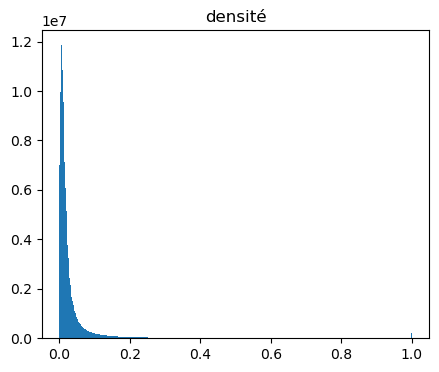

In [75]:
plt.figure(figsize=(5,4))
plt.hist(val,bins=500)#, density=True)
plt.title("densité")
#plt.xscale('log')
#plt.yscale('log')
plt.show()

In [69]:
((np.histogram(val,bins=500)[0]))

array([ 6996991,  9976181, 11850038, 11863907, 10838874,  9552758,
        8299164,  7126978,  6082920,  5161836,  4390108,  3764809,
        3231068,  2797591,  2437534,  2139603,  1891818,  1680440,
        1503511,  1353620,  1221344,  1108159,  1012797,   923401,
         843076,   778636,   717625,   666595,   618378,   574964,
         533520,   497864,   466592,   437503,   411742,   387307,
         365619,   346872,   327661,   311580,   297031,   285013,
         273526,   260660,   247910,   237728,   227239,   218056,
         209926,   202338,   193538,   186459,   179613,   173474,
         168348,   161776,   156271,   150281,   144967,   139482,
         135009,   131535,   127066,   123124,   118806,   116531,
         113019,   108229,   105116,   101824,    99309,    96435,
          93090,    90991,    87873,    85559,    83413,    81971,
          79611,    77356,    75693,    73487,    71949,    69309,
          68223,    67039,    65389,    63708,    61790,    60

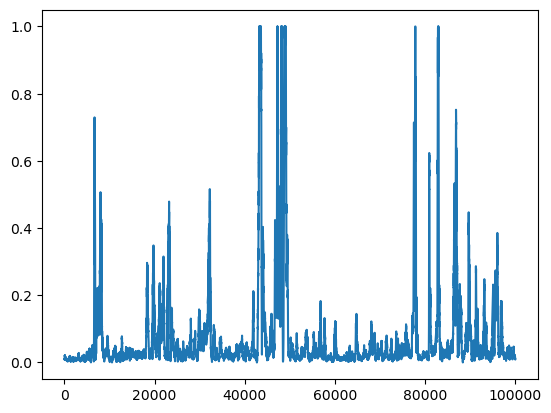

In [9]:
plt.plot((val[1000000:1100000]))

In [29]:
len((np.load('/home/florian/projet/r6.16/seq.npz')['2L']))
LEN=np.arange(1000,23512712)#fenêtre de la taille du chromosome 2L -1000 à gauche et -1001 à droite
dataset=rd.choices(LEN,k=10000)

In [30]:
#create dataset random
Yrtrain_chr2L=np.copy(val[dataset])
chr2L=np.copy(np.load('/home/florian/projet/r6.16/seq.npz')['2L'])
Xrtrain_chr2L=[]
for i in dataset:
    Xrtrain_chr2L.append(np.array(chr2L[i-1000:i+1001]))
Xrtrain_chr2L = np.array(Xrtrain_chr2L)


In [2]:
#generator
class MySequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size, max_data=2**20, WINDOW=2001):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.WINDOW = WINDOW
        n_data = min(len(self.x)-self.WINDOW+1, max_data)
        self.indices = np.arange(self.WINDOW//2, n_data+self.WINDOW//2)
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        #batch_x_indices = np.arange([idx * self.batch_size:(idx + 1) *self.batch_size])
        # batch_x = Xtrain_chr2L=[]
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        # for i in batch_indices:
        #     if i+2001 > len(self.x):
        #         break
        #     batch_x.append(self.x[i:i+2001])
        window_indices = batch_indices.reshape(-1, 1) + np.arange(-(self.WINDOW//2), self.WINDOW//2 + 1).reshape(1, -1)
        batch_x = self.x[window_indices]

        # batch_x = np.array(Xtrain_chr2L)
        batch_y = self.y[batch_indices]
        #batch_x = self.extract_windows(indices)
        return batch_x, batch_y
        return np.array([
            resize(imread(file_name), (200, 200))
               for file_name in batch_x]), np.array(batch_y)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)
    #def extract_windows(self, indices):
        # function to get windows
        # return windows

    


In [25]:
#generator weighted scikit
from sklearn.utils.class_weight import compute_sample_weight
class MySkWeightedSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size, max_data=2**20, WINDOW=2001):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.WINDOW = WINDOW
        n_data = min(len(self.x)-self.WINDOW+1, max_data)
        self.indices = np.arange(self.WINDOW//2, n_data+self.WINDOW//2)
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        window_indices = batch_indices.reshape(-1, 1) + np.arange(-(self.WINDOW//2), self.WINDOW//2 + 1).reshape(1, -1)
        batch_x = self.x[window_indices]
        batch_y = self.y[batch_indices]
        batch_weights = compute_sample_weight("balanced",batch_y)
        return batch_x, batch_y, batch_weights
        #works but weird:
        #batch_y=batch_y*compute_sample_weight("balanced",batch_y)
        #return batch_x, batch_y
        
    def on_epoch_end(self):
        np.random.shuffle(self.indices)


In [91]:
#generator weighted homebrew
from sklearn.utils.class_weight import compute_sample_weight
class MyHbWeightedSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size, max_data=2**20, WINDOW=2001):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.WINDOW = WINDOW
        n_data = min(len(self.x)-self.WINDOW+1, max_data)
        self.indices = np.arange(self.WINDOW//2, n_data+self.WINDOW//2)
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        window_indices = batch_indices.reshape(-1, 1) + np.arange(-(self.WINDOW//2), self.WINDOW//2 + 1).reshape(1, -1)
        batch_x = self.x[window_indices]
        batch_y = self.y[batch_indices]
        # batch_weights=np.array(())
        bin_values, bin_edges = np.histogram(batch_y, bins=500)
        bin_indices = np.digitize(batch_y, bin_edges)
        bin_indices[bin_indices == 501] = 500
        bin_indices -= 1
        batch_weights = 1 / bin_values[bin_indices]
        # for i in batch_y:
        #     batch_weights = np.append(batch_weights,1/np.histogram(batch_y,bins=500)[0][int(np.trunc(i*500-1))])
            # batch_weights.append(1 / bin_values[bin_indices[i]])
        return batch_x, batch_y, batch_weights
        
    def on_epoch_end(self):
        np.random.shuffle(self.indices)


In [64]:
np.sum((np.histogram(val,bins=500)[0]))

137547960

In [76]:
bin_values, bin_edges = np.histogram(val,bins=500)

In [77]:
bin_edges

array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
       0.018, 0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034,
       0.036, 0.038, 0.04 , 0.042, 0.044, 0.046, 0.048, 0.05 , 0.052,
       0.054, 0.056, 0.058, 0.06 , 0.062, 0.064, 0.066, 0.068, 0.07 ,
       0.072, 0.074, 0.076, 0.078, 0.08 , 0.082, 0.084, 0.086, 0.088,
       0.09 , 0.092, 0.094, 0.096, 0.098, 0.1  , 0.102, 0.104, 0.106,
       0.108, 0.11 , 0.112, 0.114, 0.116, 0.118, 0.12 , 0.122, 0.124,
       0.126, 0.128, 0.13 , 0.132, 0.134, 0.136, 0.138, 0.14 , 0.142,
       0.144, 0.146, 0.148, 0.15 , 0.152, 0.154, 0.156, 0.158, 0.16 ,
       0.162, 0.164, 0.166, 0.168, 0.17 , 0.172, 0.174, 0.176, 0.178,
       0.18 , 0.182, 0.184, 0.186, 0.188, 0.19 , 0.192, 0.194, 0.196,
       0.198, 0.2  , 0.202, 0.204, 0.206, 0.208, 0.21 , 0.212, 0.214,
       0.216, 0.218, 0.22 , 0.222, 0.224, 0.226, 0.228, 0.23 , 0.232,
       0.234, 0.236, 0.238, 0.24 , 0.242, 0.244, 0.246, 0.248, 0.25 ,
       0.252, 0.254,

In [83]:
bin_values[-1]

231389

In [90]:
a = np.digitize(val, bin_edges)
print(len(a[a == 500]))
print(len(a[a == 501]))
np.min(a)

2283
229106


1

In [15]:
#generates values
x=np.load('/home/florian/projet/r6.16/seq.npz')['2L']
y=np.copy(val)[:len(x)]
x_valid=np.load('/home/florian/projet/r6.16/seq.npz')['2R']
y_valid=np.copy(val)[len(x):len(x)+len(x_valid)]
gen = MySequence(x, y, 1024, max_data=2**20)
gen_valid = MySequence(x_valid, y_valid, 1024, max_data=2**14)

In [29]:
#generates scikit weighted values
x=np.load('/home/florian/projet/r6.16/seq.npz')['2L']
y=np.copy(val)[:len(x)]
x_valid=np.load('/home/florian/projet/r6.16/seq.npz')['2R']
y_valid=np.copy(val)[len(x):len(x)+len(x_valid)]
gen = MySkWeightedSequence(x, y, 1024, max_data=2**20)
gen_valid = MySkWeightedSequence(x_valid, y_valid, 1024, max_data=2**14)

In [92]:
#generates homebrew weighted values
x=np.load('/home/florian/projet/r6.16/seq.npz')['2L']
y=np.copy(val)[:len(x)]
x_valid=np.load('/home/florian/projet/r6.16/seq.npz')['2R']
y_valid=np.copy(val)[len(x):len(x)+len(x_valid)]
gen = MyHbWeightedSequence(x, y, 1024, max_data=2**20)
gen_valid = MyHbWeightedSequence(x_valid, y_valid, 1024, max_data=2**14)

In [87]:
#cor_losses
import keras.backend as K
def mae_cor(y_true, y_pred):
    """Compute loss with Mean absolute error and correlation.
        :Example:
        >>> model.compile(optimizer = 'adam', losses = mae_cor)
        >>> load_model('file', custom_objects = {'mae_cor : mae_cor})
    """
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)

    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))

    cor = sigma_XY/(sigma_X*sigma_Y + K.epsilon())
    mae = K.mean(K.abs(y_true - y_pred))

    return (1 - cor) + mae

def mse_cor(y_true, y_pred):
    """Compute loss with Mean squared error and correlation.
    """
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)

    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))

    cor = sigma_XY/(sigma_X*sigma_Y + K.epsilon())
    mse = K.sqrt(K.mean(K.abs(y_true - y_pred)**2))

    return (1 - cor) + mse

def cor(y_true, y_pred):
    """Compute correlation.
    """
    X = y_true - np.mean(y_true)
    Y = y_pred - np.mean(y_pred)

    sigma_XY = np.sum(X*Y)
    sigma_X = np.sqrt(np.sum(X*X))
    sigma_Y = np.sqrt(np.sum(Y*Y))

    cor = sigma_XY/(sigma_X*sigma_Y + K.epsilon())
    return(cor)


In [93]:
#modèle

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(128, kernel_size=(6), activation='relu', input_shape=(2001,4)),
    tf.keras.layers.MaxPooling1D(pool_size=(2)),
    tf.keras.layers.Conv1D(64, kernel_size=(12), activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=(2)),
    tf.keras.layers.Conv1D(32, kernel_size=(12), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1) #activation="sigmoid")
    ])

loss_fn = tf.keras.losses.MeanSquaredError()

model.compile(loss=mse_cor,
    optimizer='adam',
    metrics=['mae'])

In [69]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_29 (Conv1D)          (None, 1996, 128)         3200      
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 998, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_30 (Conv1D)          (None, 987, 64)           98368     
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 493, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_31 (Conv1D)          (None, 482, 32)           24608     
                                                                 
 flatten_10 (Flatten)        (None, 15424)           

In [84]:
model.fit(gen,validation_data=gen_valid,epochs=4,verbose=1)

Epoch 1/4
1024/1024 [==============================] - 700s 684ms/step - loss: 0.3118 - mae: 0.0515 - val_loss: 1.2224 - val_mae: 0.0487
Epoch 2/4
1024/1024 [==============================] - 702s 686ms/step - loss: 0.1060 - mae: 0.0226 - val_loss: 1.3327 - val_mae: 0.0508
Epoch 3/4
1024/1024 [==============================] - 702s 686ms/step - loss: 0.0701 - mae: 0.0176 - val_loss: 1.2825 - val_mae: 0.0467
Epoch 4/4
1024/1024 [==============================] - 702s 686ms/step - loss: 0.0577 - mae: 0.0151 - val_loss: 1.2886 - val_mae: 0.0460


In [53]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(128, kernel_size=(6), activation='relu', input_shape=(2001,4)),
    tf.keras.layers.MaxPooling1D(pool_size=(2)),
    tf.keras.layers.Conv1D(64, kernel_size=(12), activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=(2)),
    tf.keras.layers.Conv1D(32, kernel_size=(12), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1) #activation="sigmoid")
    ])

loss_fn = tf.keras.losses.MeanSquaredError()

model2.compile(loss=mse_cor,
    optimizer='adam',
    metrics=['mae'])

In [94]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/home/florian/projet/models/hb_weights/cp.cpkt',
                                                 save_weights_only=True,
                                                 verbose=1)
model.fit(gen,validation_data=gen_valid,epochs=2,verbose=1, callbacks=[cp_callback])


Epoch 1/2
   6/1024 [..............................] - ETA: 20:33 - loss: 0.1749 - mae: 0.4132

KeyboardInterrupt: 

In [54]:
model.load_weights('/home/florian/projet/models/trained/cp.cpkt')
model2.load_weights('/home/florian/projet/models/new_weighted_trained/cp.cpkt')

In [55]:
#create dataset section
start = 100_000
stop = start + 100_000
Ytrain_chr2L=val[start:stop]
chr2L=np.load('/home/florian/projet/r6.16/seq.npz')['2L']
Xtrain_chr2L=[]
for i in range(start,stop):
    Xtrain_chr2L.append(chr2L[i-1000:i+1001])
Xtrain_chr2L = np.array(Xtrain_chr2L)


In [ ]:
len(np.load('/home/florian/projet/r6.16/seq.npz')['2L'])

In [ ]:
#pred with old weights
pred=model.predict(x_valid, batch_size=1024) 
#pred with new weights
pred2=model2.predict(x_valid, batch_size=1024)

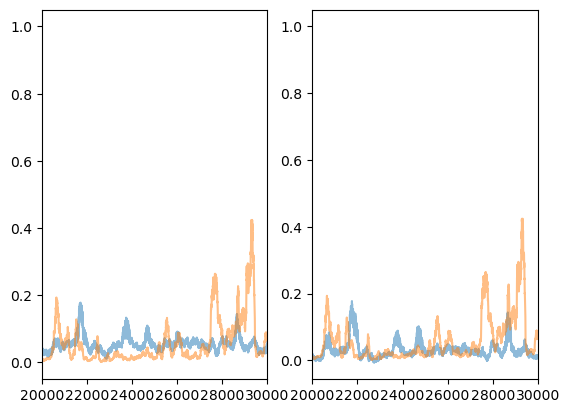

In [61]:
#prediction plot
plt.subplot(1,2,1)
plt.plot(pred,alpha=0.5)
plt.plot(y_valid,alpha=0.5)
plt.xlim((20_000, 30_000))
plt.subplot(1,2,2)
plt.plot(pred2,alpha=0.5)
plt.plot(y_valid,alpha=0.5)
plt.xlim((20_000, 30_000))
plt.show()

In [83]:
cor(Ytrain_chr2L[0:10000],pred[0:10000])

2.6301253497938612e-15

In [84]:
len(Ytrain_chr2L)

100000

(20000.0, 30000.0)

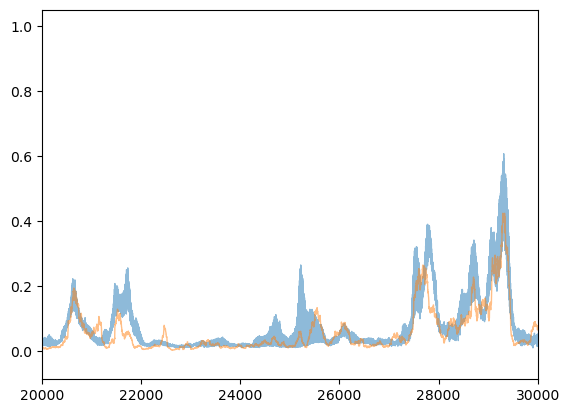

In [105]:
plt.plot(pred, alpha=0.5, linewidth=1)
plt.plot(Ytrain_chr2L, alpha=0.5, linewidth=1)
#plt.ylim((0, 0.1))
plt.xlim((20_000, 30_000))

In [37]:
for i in range(10):
    print(len(val[(0.1*i < val) & (val < 0.1*(i+1))]))
np.where((0.1 < val) & (val < 0.2))#[0]

127122856
4929055
1639222
881121
582047
424872
325513
251944
194719
139950


In [31]:
np.where((0.1 < val) & (val < 0.2))#[0]

(array([      377,       378,       379, ..., 137547944, 137547945,
        137547946]),)

In [41]:
np.concatenate((np.zeros((1, 2001, 3)), np.ones((1, 2001, 1))), axis=-1).shape

(1, 2001, 4)